In [1]:
################################################################################
# INSTALL CONDA ON GOOGLE COLAB
################################################################################
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-09-01 16:01:42--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M  96.3MB/s    in 0.8s    

2021-09-01 16:01:43 (96.3 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37

In [2]:
! conda install -c rdkit rdkit -y

Solving environment: | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    bottleneck-1.3.2           |   py37heb32a55_1         125 KB
    bzip2-1.0.8                |       h7b6447c_0          78 KB
    ca-certificates-2021.7.5   |       h06a4308_1         113 KB
    cairo-1.16.0               |       hf32fb01_1         1.0 MB
    certifi-2021.5.30          |   py37h06a4308_0         139 KB
    conda-4.10.3               |   py37h06a4308_0         2.9 MB
    fontconfig-2.13.1          |       h6c09931_0         250 KB
    freetype-2.10.4            |       h5ab3b9f_0         596 KB
    glib-2.69.1                |       h5202010_0         1.7 MB
    icu-58.2                   |

In [3]:
import rdkit

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
from xgboost import XGBRegressor
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import io
from PIL import Image
from sklearn.metrics import roc_curve, roc_auc_score
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from collections import defaultdict

**Loading the Data**

read the training data, convert the "activity" field to an integer, and add a fingerprint column (morgan fingerprints are used in this example)

In [5]:
df_train = PandasTools.LoadSDF("N_train_lbl.sdf")
df_train.activity = df_train.activity.astype(int)
df_train['fp'] = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(df_train.ROMol)]

  0%|          | 0/6995 [00:00<?, ?it/s]

,N,ids,activity,lbls,ID,ROMol,fp
0,2,"19,23",2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...",CHEMBL379993,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

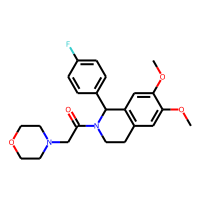

In [6]:
df_train.head(1)

read the test data, convert the "activity" field to an integer and add a fingerprint column (morgan fingerprints)

In [7]:
df_test = PandasTools.LoadSDF("N_test_lbl.sdf")
df_test.activity = df_test.activity.astype(int)
df_test['fp'] = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(df_test.ROMol)]

  0%|          | 0/2999 [00:00<?, ?it/s]

extract the X and y variables from the training dataframe

In [9]:
train_X = np.asarray(list(df_train.fp.values))
train_y = df_train.activity.values

**Building a Simple Machine Learning Model**

In [10]:
xgb = XGBRegressor()

In [11]:
xgb.fit(train_X,train_y)

[16:19:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Extract the X and y variables from the test dataframe.

In [12]:
test_X = np.asarray(list(df_test.fp.values))
test_y = df_test.activity.values

Predict on the test set

In [13]:
test_pred = xgb.predict(test_X)

Plot the predictions as a violinplot

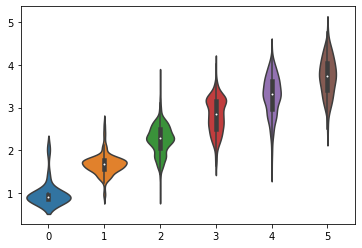

In [14]:
sns.violinplot(x=test_y, y=test_pred);

**Intepreting the Model**

> grabbing the first molecule in the training set. We notice this molecule has 2 nitrogen atoms, with indices 18 and 22

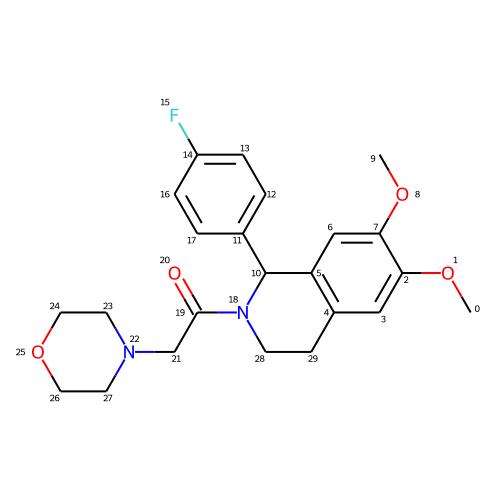

In [15]:
example_mol = Chem.Mol(df_train.ROMol.values[0])
d2d = rdMolDraw2D.MolDraw2DSVG(500,500)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(example_mol)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())



> generate a fingerprint for this molecule and use our model to predict its activity (number of nitrogens). Note that the number of nitrogens is predicted to be 1.7, rather than 2.



In [16]:
example_fp = AllChem.GetMorganFingerprintAsBitVect(example_mol,2)
example_pred = xgb.predict(np.array([example_fp]))[0]
example_pred

1.7000709

**Mask each atom to identify the contributions of each atom onto prediction of the molecule's activity.**

One way of assessing the importance of atoms to a predicted activity is to **"mask" each atom** and predict the activity using a fingerprint generated with the masked atom. If the prediction with the "masked" atom is similar to the prediction with the original molecule, that atom has little impact on the prediction. On the other hand, if masking the atom makes a large change in the prediction, we consider that atom important. We can use the function SimilarityMaps.GetMorganFingerprint to generate a fingerprint with an atom masked. This function takes two arguments, the input molecule, and the index of the atom to be masked.

below, it loops over atoms, generates a fingerprint with each atom masked, and generates a prediction with the masked fingerprint. At each iteration, it records the predicted activity and "delta", the difference between the activity of the original molecule with no atoms masked and the new molecule with one atom masked. This data is collected and displayed in a dataframe that is sorted by delta. As it can be seen in the resulting table, the two nitrogen atoms 18 and 22, have the highest values for delta

In [17]:
res = []
for atm in example_mol.GetAtoms():
    idx = atm.GetIdx()
    fp = SimilarityMaps.GetMorganFingerprint(example_mol,idx)
    pred_val = xgb.predict(np.array([fp]))[0]
    delta = example_pred - pred_val
    res.append([atm.GetSymbol(),idx,pred_val,delta])
tmp_df = pd.DataFrame(res,columns = ["Atom Type","Atom Index","Predicted Value","Delta"])
tmp_df.sort_values("Delta",ascending=False)

,Atom Type,Atom Index,Predicted Value,Delta
22,N,22,0.833391,0.866679
18,N,18,0.895023,0.805048
27,C,27,1.533585,0.166486
23,C,23,1.533585,0.166486
29,C,29,1.570431,0.129640
28,C,28,1.570431,0.129640
26,C,26,1.570431,0.129640
24,C,24,1.570431,0.129640
21,C,21,1.638439,0.061631
19,C,19,1.675285,0.024786


**use the SimilarityMaps feature from the RDKit to project the importance of each atom onto the chemical structure**

The darker colored atoms are considered to be more important

In [18]:
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

def get_pred(fp, pred_function):
    fp = np.array([list(fp)])
    return pred_function(fp)[0]

def plot_similarity_map(mol, model):
    d = Draw.MolDraw2DCairo(400, 400)
    SimilarityMaps.GetSimilarityMapForModel(mol,
                                            SimilarityMaps.GetMorganFingerprint,
                                            lambda x : get_pred(x, model.predict),
                                            draw2d=d)
    d.FinishDrawing()
    return d

Display the similarity map for the predictions. The variable test_row in the table below corresponds to the row in df_test that will be displayed

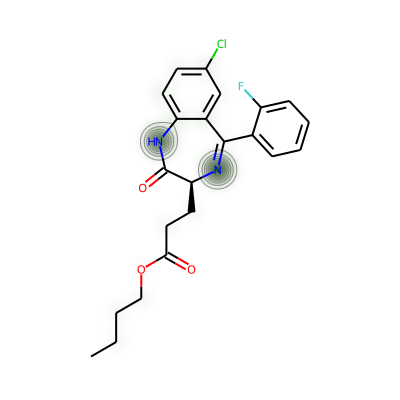

In [19]:
test_row = 1
test_mol = df_test.ROMol.values[test_row]
res = plot_similarity_map(test_mol,xgb);
show_png(res.GetDrawingText())

**Evaluating the Interpretations**

The function SimilarityMaps.GetAtomicWeightsForModel wraps the masking operation described above into a single line of code

In [20]:
aw = SimilarityMaps.GetAtomicWeightsForModel(test_mol,
                                        SimilarityMaps.GetMorganFingerprint,
                                        lambda x : get_pred(x, xgb.predict))
aw = np.array(aw)

Convert the weights and associated atom types to a dataframe. For the test molecule in row 1, the two nitrogens have the largest weights.

In [21]:
wt_df = pd.DataFrame(zip([atm.GetSymbol() for atm in test_mol.GetAtoms()],aw),columns=["Symbol","Weight"])
wt_df.sort_values("Weight",ascending=False)

,Symbol,Weight
10,N,0.728125
26,N,0.614410
24,C,0.054679
21,C,0.054679
25,C,0.054679
19,C,0.054679
23,C,0.033696
2,C,0.031062
3,C,0.031062
7,C,0.031062


compare the weights with the "correct" weights, which are in the "lbls" field of the dataframe.

In [22]:
test_labels = df_test.lbls[test_row]
test_label_array = np.fromstring(test_labels,sep=",",dtype=int)

In [23]:
test_label_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0])

One of the simplest ways is to compare the predicted and actual weights is to treat this as a classification problem and calculate the area under the Receiver Operating Characteristic (ROC) curve, which plots the false positive rate vs the true positive rate

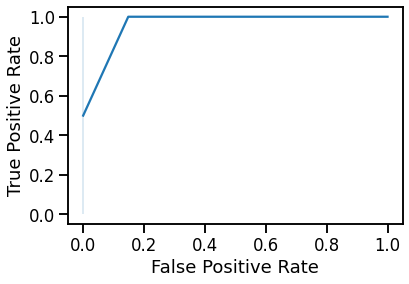

In [24]:
sns.set_context('talk')
fpr, tpr, thresholds = roc_curve(test_label_array, aw)
ax = sns.lineplot(x=fpr,y=tpr)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate");

use sklearn to calculate the area under the ROC curve

In [25]:
roc_auc_score(test_label_array,aw)

1.0

AUC considers the weights on all atoms. If only interested in the "top N" predictions, use this Python function to calcuate the top_n score for a molecule 

In [26]:
def top_n(ref, pred):
    n = int(np.sum(ref))
    top_ref_idx = ref.argsort()[-n:][::-1]
    top_pred_idx = pred.argsort()[-n:][::-1]
    num_common = len(set(top_ref_idx).intersection(set(top_pred_idx)))
    return num_common/float(n)

calculate the AUC and top_n score for the first 100 test molecules. also save a list of molecules with a top_n_score < 1.0 to examine it later.

In [27]:
auc_list = []
top_n_score_list = []
top_n_lt_1_list = []
idx = 0
for mol, label in tqdm(df_test[["ROMol","lbls"]].head(100).values):
    aw = SimilarityMaps.GetAtomicWeightsForModel(mol,
                                        SimilarityMaps.GetMorganFingerprint,
                                        lambda x : get_pred(x, xgb.predict))
    if label != "NA":
        label_array = np.fromstring(label,sep=",",dtype=int)
        auc_list.append(roc_auc_score(label_array,aw))
        top_n_score = top_n(label_array,np.array(aw))
        top_n_score_list.append(top_n_score)
        if top_n_score < 1:
            top_n_lt_1_list.append([idx,top_n_score])
    idx+=1
print(f"Mean AUC = {np.mean(auc_list):.2f}")
print(f"Mean top_n = {np.mean(top_n_score_list):.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean AUC = 0.99
Mean top_n = 0.95


Create a dataframe with the rows where the top_n score was less than 1. It's interesting that in 10 of 100 cases, it fails to assign the nitrogens atoms as critical features.

In [28]:
pd.DataFrame(top_n_lt_1_list,columns=["Row","Top_n_score"])

,Row,Top_n_score
0,7,0.500000
1,10,0.750000
2,33,0.666667
3,44,0.666667
4,60,0.000000
5,66,0.500000
6,67,0.500000
7,68,0.666667
8,84,0.750000
9,87,0.666667


define a debugging function that will enable us to compare the top n predictions with the top n labels

In [29]:
def debug_row(df, idx):
    red = (1,0,0)
    blue = (0,0,1)
    mol = df.loc[[idx]].ROMol.values[0]
    mol = Chem.Mol(mol)
    label = df.loc[idx].lbls
    label_array = np.fromstring(label,sep=",",dtype=int)
    n = int(sum(label_array))        
    aw = SimilarityMaps.GetAtomicWeightsForModel(mol,
                                        SimilarityMaps.GetMorganFingerprint,
                                        lambda x : get_pred(x, xgb.predict))
    aw = np.array(aw)
    top_idx = aw.argsort()[-n:][::-1]
    top_idx = [int(x) for x in top_idx]
    # set the drawing options
    d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
    dos = d2d.drawOptions()
    dos.atomHighlightsAreCircles = True
    dos.fillHighlights=False
    # set the highlight color for the top n predicted atoms to red
    top_dict = defaultdict(list)
    highlight_rads = {}
    for t in top_idx:
        top_dict[t].append(red)
    # set the colors for the top n labeled atoms to red
    for a in label_array.argsort()[-n:]:
        top_dict[int(a)].append(blue)
    # set the radii for the highlight circles
    for k,v in top_dict.items():
        highlight_rads[k] = 0.6
    d2d.DrawMoleculeWithHighlights(mol," ",dict(top_dict),{},highlight_rads,{})
    d2d.FinishDrawing()
    return d2d

output from our debugging function. Correctly predicted atoms are shown as circles that are half red and half blue. Incorrectly predicted atoms are shown as red circles, atoms that are "missed" are shown as blue circles.

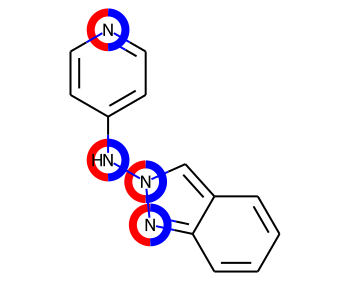

In [31]:
mistake_row = 3
res = debug_row(df_test,mistake_row)
SVG(res.GetDrawingText())